In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# read the CSV file into a DataFrame object
energy_dataset = pd.read_csv(r'C:\Users\torst\anaconda3\O4\Datat\Energy and weather datasets\energy_dataset.csv')
weather_dataset = pd.read_csv(r'C:\Users\torst\anaconda3\O4\Datat\Energy and weather datasets\weather_features.csv')

# Prune weather and energy data 
weather_dataset.drop('weather_main', inplace=True, axis=1)
weather_dataset.drop('weather_description',inplace=True, axis=1)
weather_dataset.drop('pressure',inplace=True, axis=1)
weather_dataset.drop('rain_1h',inplace=True, axis=1)
weather_dataset.drop('rain_3h',inplace=True, axis=1)
weather_dataset.drop('snow_3h',inplace=True, axis=1)
weather_dataset.drop('weather_id',inplace=True, axis=1)


energy_dataset.drop('generation fossil coal-derived gas', inplace=True, axis=1)
energy_dataset.drop('generation fossil peat', inplace=True, axis=1)
energy_dataset.drop('generation geothermal', inplace=True, axis=1)
energy_dataset.drop('generation fossil oil shale', inplace=True, axis=1)
energy_dataset.drop('forecast wind offshore eday ahead', inplace=True, axis=1)
energy_dataset.drop('generation hydro pumped storage aggregated', inplace=True, axis=1)
energy_dataset.drop('generation marine', inplace=True, axis=1)
energy_dataset.drop('generation wind offshore', inplace=True, axis=1)

# mean all the cities 
weather_dataset_mean = weather_dataset.groupby('dt_iso', as_index=False).mean()

weather_dataset_mean = weather_dataset_mean.rename(columns={'dt_iso': 'time'})
# merge the datasets on their datetime index
merged_dataset = pd.merge(energy_dataset, weather_dataset_mean, left_index=False, right_index=False)




In [12]:
# Compute the correlation matrix
correlation_matrix = merged_dataset.corr()

# Extract the correlation values for "price day ahead" with other features
price_corr = correlation_matrix.loc["price day ahead"]

# Sort the correlation values in descending order
sorted_corr = price_corr.abs().sort_values(ascending=False)

# Display the ranked correlation values
print("Ranked correlation matrix for merged dataset:")
print(sorted_corr)


Ranked correlation matrix for merged dataset:
price day ahead                                1.000000
price actual                                   0.732155
generation fossil hard coal                    0.671596
generation fossil gas                          0.640895
generation hydro pumped storage consumption    0.600460
generation fossil brown coal/lignite           0.567905
total load forecast                            0.474649
total load actual                              0.473869
forecast wind onshore day ahead                0.428874
generation other renewable                     0.428078
generation wind onshore                        0.424899
generation waste                               0.368036
generation hydro run-of-river and poundage     0.294718
generation fossil oil                          0.292793
wind_deg                                       0.161827
wind_speed                                     0.124252
generation biomass                             0.108945
te

In [ ]:
merged_dataset = merged_dataset.fillna(0)

# calculate the discrepancy of the actual price and the price day ahead.
price_actual = merged_dataset['price actual'].values
price_day_ahead = merged_dataset['price day ahead'].values

# our prediction
price_discrep = abs(price_actual-price_day_ahead)

merged_dataset.drop('price actual',inplace=True, axis=1)
#merged_dataset.drop('price day ahead',inplace=True, axis=1)

time_stamps = merged_dataset['time']
merged_dataset.drop('time', inplace=True, axis=1)

merged_dataset.drop('generation hydro pumped storage consumption', inplace=True, axis=1)
merged_dataset.drop('generation fossil brown coal/lignite', inplace=True, axis=1)


generationList = ["generation biomass", "generation fossil gas", "generation fossil hard coal",
            "generation fossil oil","generation hydro run-of-river and poundage",
            "generation hydro water reservoir","generation nuclear","generation other",
            "generation other renewable","generation solar","generation waste",
            "generation wind onshore","total load actual","temp","temp_min","temp_max","humidity",
            "wind_speed","wind_deg","clouds_all"]

newDataset = merged_dataset[generationList]

merged_dataset.drop(generationList, inplace=True, axis=1)

newDataset_24h_ago = newDataset.shift(-24)  # Shift X by 24 rows to represent data from 24 hours ago

merged_dataset['time'] = time_stamps

newDataset_24h_ago['time'] = time_stamps

merged_24_dataset = pd.merge(newDataset_24h_ago, merged_dataset, left_index=False, right_index=False)

merged_24_dataset = merged_24_dataset[:-24]

merged_24_dataset.drop("time", inplace=True, axis=1)

merged_24_dataset.hist(bins=100, figsize=(50,50))
plt.show

price_discrep = price_discrep[:-24]

In [102]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

X = merged_24_dataset
y = price_discrep

    
X_train, X_val, y_train, y_val = \
    train_test_split( \
        X, y, shuffle=True, \
        test_size=0.5, \
        random_state=42)


degrees = [1, 2]

for i in range(len(degrees)):

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression)
        ])
    X_train_poly = pipeline.fit(X_train, y_train)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
    
    score_mean = scores.mean()
    print(f"  degree={degrees[i]:4d}, score_mean={score_mean:4.2f},  {polynomial_features}") 
    for i in range(len(scores)):
       print(f"      CV fold {i}  =>  score = {scores[i]:.2}")




  degree=   1, score_mean=-54.53,  PolynomialFeatures(degree=1, include_bias=False)
      CV fold 0  =>  score = -5.3e+01
      CV fold 1  =>  score = -5.4e+01
      CV fold 2  =>  score = -5.6e+01
      CV fold 3  =>  score = -5.6e+01
      CV fold 4  =>  score = -5.2e+01
      CV fold 5  =>  score = -5.1e+01
      CV fold 6  =>  score = -5.7e+01
      CV fold 7  =>  score = -5.6e+01
      CV fold 8  =>  score = -5.5e+01
      CV fold 9  =>  score = -5.7e+01
  degree=   2, score_mean=-40.00,  PolynomialFeatures(include_bias=False)
      CV fold 0  =>  score = -3.5e+01
      CV fold 1  =>  score = -4.2e+01
      CV fold 2  =>  score = -4.1e+01
      CV fold 3  =>  score = -4e+01
      CV fold 4  =>  score = -3.5e+01
      CV fold 5  =>  score = -3.9e+01
      CV fold 6  =>  score = -5.5e+01
      CV fold 7  =>  score = -3.9e+01
      CV fold 8  =>  score = -3.6e+01
      CV fold 9  =>  score = -3.8e+01


In [ ]:

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled   = poly_scaler.transform(X_val)


def Train(X_train, y_train, X_val, y_val, n_epochs, verbose=False):
    print("Training...n_epochs=",n_epochs)
    
    train_errors, val_errors = [], []
    
    sgd_reg = SGDRegressor(max_iter=10,
                           penalty=None,
                           eta0=0.005,
                           warm_start=True,
                           early_stopping=False,
                           learning_rate="constant",
                           tol=-float("inf"),
                           random_state=42)

    for epoch in range(n_epochs):
        
        sgd_reg.fit(X_train, y_train)
        
        y_train_predict = sgd_reg.predict(X_train)
        y_val_predict   = sgd_reg.predict(X_val)
    

        mse_train=mean_squared_error(y_train, y_train_predict)
        mse_val  =mean_squared_error(y_val  , y_val_predict)
        
        
        train_errors.append(mse_train)
        val_errors  .append(mse_val)
        if verbose:
            print(f"  epoch={epoch:4d}, mse_train={mse_train:4.2f}, mse_val={mse_val:4.2f}")

    return train_errors, val_errors

n_epochs = 500
train_errors, val_errors = Train(X_train_poly_scaled, y_train, X_val_poly_scaled, y_val, n_epochs, True)


Training...n_epochs= 500
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-3.10451767e+11 -1.40748669e+11 -3.27892539e+11  4.96016018e+10]
  epoch=   0, mse_train=61035599366302505893888.00, mse_val=60473320171826501910528.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-6.51072690e+11 -1.97863601e+09 -2.43314122e+11 -1.29203817e+11]
  epoch=   1, mse_train=80047513367278254030848.00, mse_val=78996070342062753447936.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [3.33513065e+11 1.13523817e+11 2.44467148e+11 1.33689754e+11]
  epoch=   2, mse_train=34683898858967599677440.00, mse_val=33303703170870537093120.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-3.62906285e+11 -1.95722664e+11 -1.87342307e+11  3.43730308e+11]
  epoch=   3, mse_train=91486999141050025508864.00, mse_val=90886565597131426496512.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 3.72867502e+11  2.11461814e+11  1.51505798e+11 -3.49860854e+11]
  epoch=   4, mse_train=85549898380481457553408.00, mse_val=84819448852416626163712.00

Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-4.15945653e+11 -2.10750519e+11 -1.60732842e+11  3.17330208e+11]
  epoch=  42, mse_train=86347392235067934769152.00, mse_val=85641361143295134138368.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-5.89998080e+11  1.76827332e+10 -2.37126742e+11 -9.76259055e+10]
  epoch=  43, mse_train=46983554581426637635584.00, mse_val=46373542086176854245376.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-4.16906119e+11 -9.44555301e+10 -3.08161273e+11  8.09125423e+10]
  epoch=  44, mse_train=59203373012105367126016.00, mse_val=59133200048878256128000.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-3.44908009e+11 -2.04539212e+11 -1.79694956e+11  3.47089569e+11]
  epoch=  45, mse_train=86184623484894833541120.00, mse_val=85579641256541780180992.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-4.39244156e+11  1.52825945e+10 -2.58559085e+11 -1.90525181e+11]
  epoch=  46, mse_train=32425424990523417952256.00, mse_val=31933666760929079984128.00
Y_val: [ 8.84  6.58 

Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-6.62396273e+11  2.07810371e+10 -2.69251917e+11 -2.31720945e+11]
  epoch=  84, mse_train=60292778788967409516544.00, mse_val=59183610362018945564672.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-4.58534587e+11 -1.21366632e+11 -2.27041116e+11  1.84510145e+11]
  epoch=  85, mse_train=89599738738319762128896.00, mse_val=89367847406460626534400.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-4.36031792e+11 -1.45720456e+11 -1.80741593e+11  2.44379708e+11]
  epoch=  86, mse_train=83600040362517179924480.00, mse_val=83406919272977416585216.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-3.59488996e+11 -1.92174969e+11 -1.56721781e+11  3.57796210e+11]
  epoch=  87, mse_train=87418368373901011976192.00, mse_val=86676065235315583877120.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [2.62937306e+11 9.72744630e+10 1.12342884e+11 1.00100488e+11]
  epoch=  88, mse_train=13048718884986698072064.00, mse_val=12556019074353011359744.00
Y_val: [ 8.84  6.58  5.7

Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 4.13650162e+11  1.68993822e+11  1.68915752e+11 -2.45107482e+11]
  epoch= 126, mse_train=83778549918726078070784.00, mse_val=83061768220671859490816.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [5.96911394e+11 6.67054818e+10 2.33586681e+11 3.28057454e+10]
  epoch= 127, mse_train=75210975417734031998976.00, mse_val=74633095260057221726208.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 4.01815042e+11 -1.60812009e+10  1.52912418e+11  7.75481551e+10]
  epoch= 128, mse_train=22908417583813381586944.00, mse_val=22623214367460577771520.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [5.92953437e+11 3.18477712e+10 2.66571863e+11 8.31636309e+10]
  epoch= 129, mse_train=57198768880462331904000.00, mse_val=56528129065945770491904.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-3.90685185e+10 -1.09123337e+11 -1.46127871e+11 -6.01504723e+10]
  epoch= 130, mse_train=20169128023770441711616.00, mse_val=20160467862199725981696.00
Y_val: [ 8.84  6.58  5.71 27

Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 4.15359608e+11  1.62794208e+11  1.85814915e+11 -2.17407522e+11]
  epoch= 168, mse_train=76358393797833878667264.00, mse_val=76321874810023792607232.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 5.81372563e+11  7.17277741e+10  1.68825764e+11 -4.48505838e+10]
  epoch= 169, mse_train=89259574695512007245824.00, mse_val=88690433048743143014400.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 4.45881707e+11  1.39981322e+11  1.69902076e+11 -1.88676825e+11]
  epoch= 170, mse_train=84160112476181147680768.00, mse_val=83341536744649103769600.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 4.41924233e+11  1.48938531e+11  1.70661192e+11 -1.91950038e+11]
  epoch= 171, mse_train=80928951408372672888832.00, mse_val=80106627157236444561408.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 3.55834914e+11  1.64343433e+11  1.74669637e+11 -3.31166792e+11]
  epoch= 172, mse_train=82065317944894660018176.00, mse_val=80939771355153888706560.00
Y_val: [ 8.84  6.58 

Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 3.27548367e+11  1.91893831e+11  1.85596957e+11 -3.72460277e+11]
  epoch= 210, mse_train=80471389410480986521600.00, mse_val=79660894560768120324096.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 5.63891324e+11 -1.01727740e+10  2.34706775e+11  3.01914309e+10]
  epoch= 211, mse_train=41627133646681336184832.00, mse_val=41044052162192634544128.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 4.28955605e+11  1.53306995e+11  2.32420150e+11 -1.50700619e+11]
  epoch= 212, mse_train=89611287824983931224064.00, mse_val=88549194805937596006400.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [6.08959904e+11 1.97058446e+10 2.74059107e+11 6.10264259e+10]
  epoch= 213, mse_train=62978513301525661483008.00, mse_val=62163233095226402799616.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 3.27340524e+11  1.95147680e+11  1.76840023e+11 -3.75171238e+11]
  epoch= 214, mse_train=86268571262229946564608.00, mse_val=85657918381262978940928.00
Y_val: [ 8.84  6.58  5.7

Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-4.60293149e+11 -7.08606479e+10 -2.34016258e+11 -1.44208748e+11]
  epoch= 252, mse_train=26652797684975910518784.00, mse_val=25716638192444612018176.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 3.62238363e+11  2.24975024e+11  2.18663034e+11 -3.10246218e+11]
  epoch= 253, mse_train=90933387022165675606016.00, mse_val=90288553453428882276352.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-2.46628364e+11 -4.97037359e+10 -1.45769569e+11 -1.25725645e+11]
  epoch= 254, mse_train=14211937506125980631040.00, mse_val=13845479436252396650496.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-6.18910278e+11 -5.96299655e+09 -2.41352499e+11 -2.42127144e+11]
  epoch= 255, mse_train=56950172998950035914752.00, mse_val=56058414618318966095872.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-4.16568115e+11 -1.62826839e+11 -1.65446778e+11  2.27368101e+11]
  epoch= 256, mse_train=91198791999866582073344.00, mse_val=90543938471656972877824.00
Y_val: [ 8.84  6.58 

Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-5.89650886e+11 -4.49805267e+10 -3.10397345e+11 -1.61571928e+11]
  epoch= 294, mse_train=49875214083689696722944.00, mse_val=49192279050813649715200.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-6.24716479e+11 -2.74496249e+10 -2.50501208e+11 -2.78930071e+10]
  epoch= 295, mse_train=64665367936870211649536.00, mse_val=63937589332882789236736.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-5.94860273e+11 -3.64917040e+10 -2.43841055e+11 -7.96151770e+08]
  epoch= 296, mse_train=67741605923074095448064.00, mse_val=67145643119527495467008.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-5.23677820e+11 -7.18670367e+10 -2.55380880e+11  8.07617718e+10]
  epoch= 297, mse_train=67658291232095820840960.00, mse_val=67177370761542825410560.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-6.22487484e+11 -4.86371886e+10 -2.42657597e+11 -1.84326592e+10]
  epoch= 298, mse_train=70822899692257805336576.00, mse_val=70182440717592926617600.00
Y_val: [ 8.84  6.58 

Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [5.93069418e+11 3.86138536e+10 2.43037877e+11 2.96582645e+10]
  epoch= 336, mse_train=76035832726309130207232.00, mse_val=75233938778059360436224.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 4.39978492e+11  1.47711329e+11  1.91519052e+11 -2.01968579e+11]
  epoch= 337, mse_train=62433727467079965081600.00, mse_val=62375841795877583716352.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 3.87088553e+11  1.84147023e+11  2.13772613e+11 -2.53270943e+11]
  epoch= 338, mse_train=78440331808636523249664.00, mse_val=77684648199010534817792.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 6.35607078e+11 -1.28135911e+10  2.76413857e+11  1.25342638e+11]
  epoch= 339, mse_train=51514797945274392117248.00, mse_val=50732159630174068932608.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [ 2.05754249e+11 -5.95948862e+10  3.92082459e+08 -5.72079472e+10]
  epoch= 340, mse_train=11988478256787325190144.00, mse_val=11852837539021322190848.00
Y_val: [ 8.84  6.58  5.7

Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [5.78948280e+10 6.04448290e+10 1.93317450e+11 1.53377151e+11]
  epoch= 378, mse_train=19537524792020961329152.00, mse_val=19546550324063350292480.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-4.64442933e+11 -5.25555134e+10 -3.08939638e+11  1.31602403e+10]
  epoch= 379, mse_train=44554559364530628984832.00, mse_val=44333803669435577270272.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-5.65296597e+11 -1.12483968e+11 -2.20937936e+11  2.21842908e+10]
  epoch= 380, mse_train=79899464278312650539008.00, mse_val=79564134644646311624704.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-3.62871761e+11 -2.10596849e+11 -1.96837467e+11  2.66564595e+11]
  epoch= 381, mse_train=84738985214349729071104.00, mse_val=84286589816010702848000.00
Y_val: [ 8.84  6.58  5.71 27.92] , Y_Pred: [-3.50870887e+11 -1.98982397e+11 -2.19102500e+11  2.90565242e+11]
  epoch= 382, mse_train=76144163579088055828480.00, mse_val=75329781096217434914816.00
Y_val: [ 8.84  6.58  5.7

In [ ]:
import matplotlib.pyplot as plt
weather_dataset.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
corr_matrix = energy_dataset.corr()
corr_matrix["price day ahead"].sort_values(ascending=False)


price day ahead                                1.000000
price actual                                   0.732155
generation fossil hard coal                    0.671596
generation fossil gas                          0.640895
generation fossil brown coal/lignite           0.567905
total load forecast                            0.474649
total load actual                              0.473869
generation other renewable                     0.428078
generation waste                               0.368036
generation fossil oil                          0.292793
generation biomass                             0.108945
forecast solar day ahead                       0.062118
generation solar                               0.058392
generation other                               0.043599
generation hydro water reservoir              -0.017807
generation nuclear                            -0.044189
generation hydro run-of-river and poundage    -0.294718
generation wind onshore                       -0

In [12]:

# set the 'time' column as the index in both datasets
energy_dataset.set_index('time', inplace=True)
weather_dataset.set_index('dt_iso', inplace=True)

# merge the datasets on their datetime index
merged_dataset = pd.merge(energy_dataset, weather_dataset, left_index=True, right_index=True)

# reset the index if needed
merged_dataset.reset_index(inplace=True)



In [13]:
energy_dataset.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [14]:
weather_dataset.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
dt_iso,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


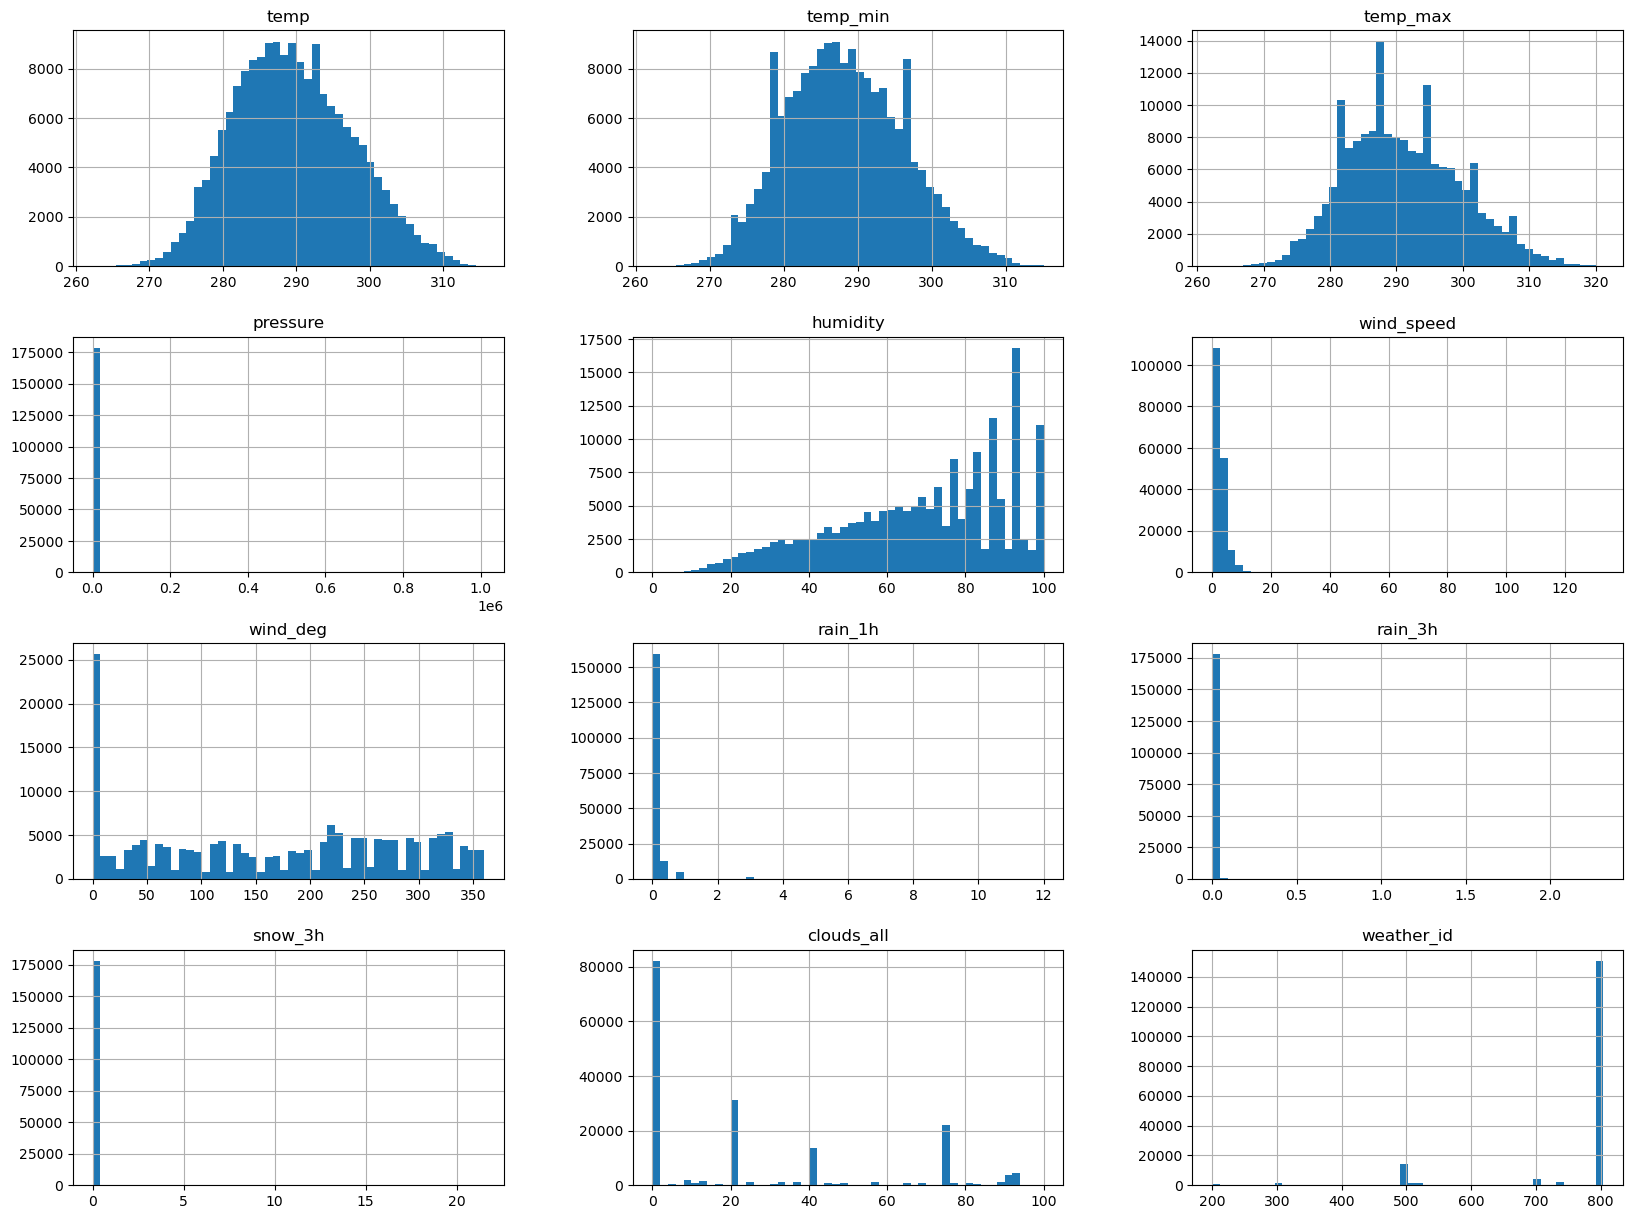

In [15]:
weather_dataset.hist(bins=50, figsize=(20,15))
plt.show()

In [16]:
# downsample the weather dataset to match the number of samples in the energy dataset
downsampled_weather = weather_dataset.iloc[::5, :]  # take every 5th row

In [17]:
# merge the datasets on their datetime index
downsampled_merged_dataset = pd.merge(energy_dataset, downsampled_weather, left_index=True, right_index=True)

# reset the index if needed
downsampled_merged_dataset.reset_index(inplace=True)

In [18]:
corr_matrix = downsampled_merged_dataset.corr()
corr_matrix["price day ahead"].sort_values(ascending=False)
downsampled_merged_dataset.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,35665.000000,35665.000000,35665.0,35665.000000,35665.000000,35665.000000,35665.0,35665.0,35665.0,0.0,...,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000,35680.000000
mean,382.967671,448.161279,0.0,5624.622964,4252.669368,298.104136,0.0,0.0,0.0,NaN,...,291.090465,1041.275701,68.434613,2.475729,166.873487,0.076059,0.000363,0.004958,24.956222,759.631586
std,85.244758,354.182715,0.0,2205.832635,1961.127526,52.459882,0.0,0.0,0.0,NaN,...,8.614435,1579.100683,21.922894,2.181761,116.556130,0.404531,0.004824,0.226786,30.710525,108.823398
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,262.240000,594.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,333.000000,0.000000,0.0,4121.000000,2523.000000,263.000000,0.0,0.0,0.0,NaN,...,284.650000,1013.000000,53.000000,1.000000,56.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,366.000000,509.000000,0.0,4974.000000,4470.000000,300.000000,0.0,0.0,0.0,NaN,...,290.150000,1018.000000,72.000000,2.000000,178.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,430.000000,756.000000,0.0,6436.000000,5835.000000,329.000000,0.0,0.0,0.0,NaN,...,297.150000,1022.000000,87.000000,4.000000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,592.000000,999.000000,0.0,20034.000000,8315.000000,445.000000,0.0,0.0,0.0,NaN,...,320.150000,101983.000000,100.000000,133.000000,360.000000,12.000000,0.100000,21.500000,100.000000,804.000000


In [19]:
corr_matrix = merged_dataset.corr()
corr_matrix["price day ahead"].sort_values(ascending=False)
merged_dataset.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178301.000000,178306.000000,178306.0,178306.000000,178306.000000,178301.000000,178306.0,178306.0,178306.0,0.0,...,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,382.999002,448.256890,0.0,5626.254428,4254.162345,298.149651,0.0,0.0,0.0,NaN,...,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,85.256652,354.297585,0.0,2203.888156,1960.883415,52.464334,0.0,0.0,0.0,NaN,...,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,333.000000,0.000000,0.0,4127.000000,2526.000000,263.000000,0.0,0.0,0.0,NaN,...,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,366.000000,509.000000,0.0,4972.000000,4473.000000,300.000000,0.0,0.0,0.0,NaN,...,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,430.000000,757.000000,0.0,6435.000000,5836.000000,330.000000,0.0,0.0,0.0,NaN,...,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,...,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


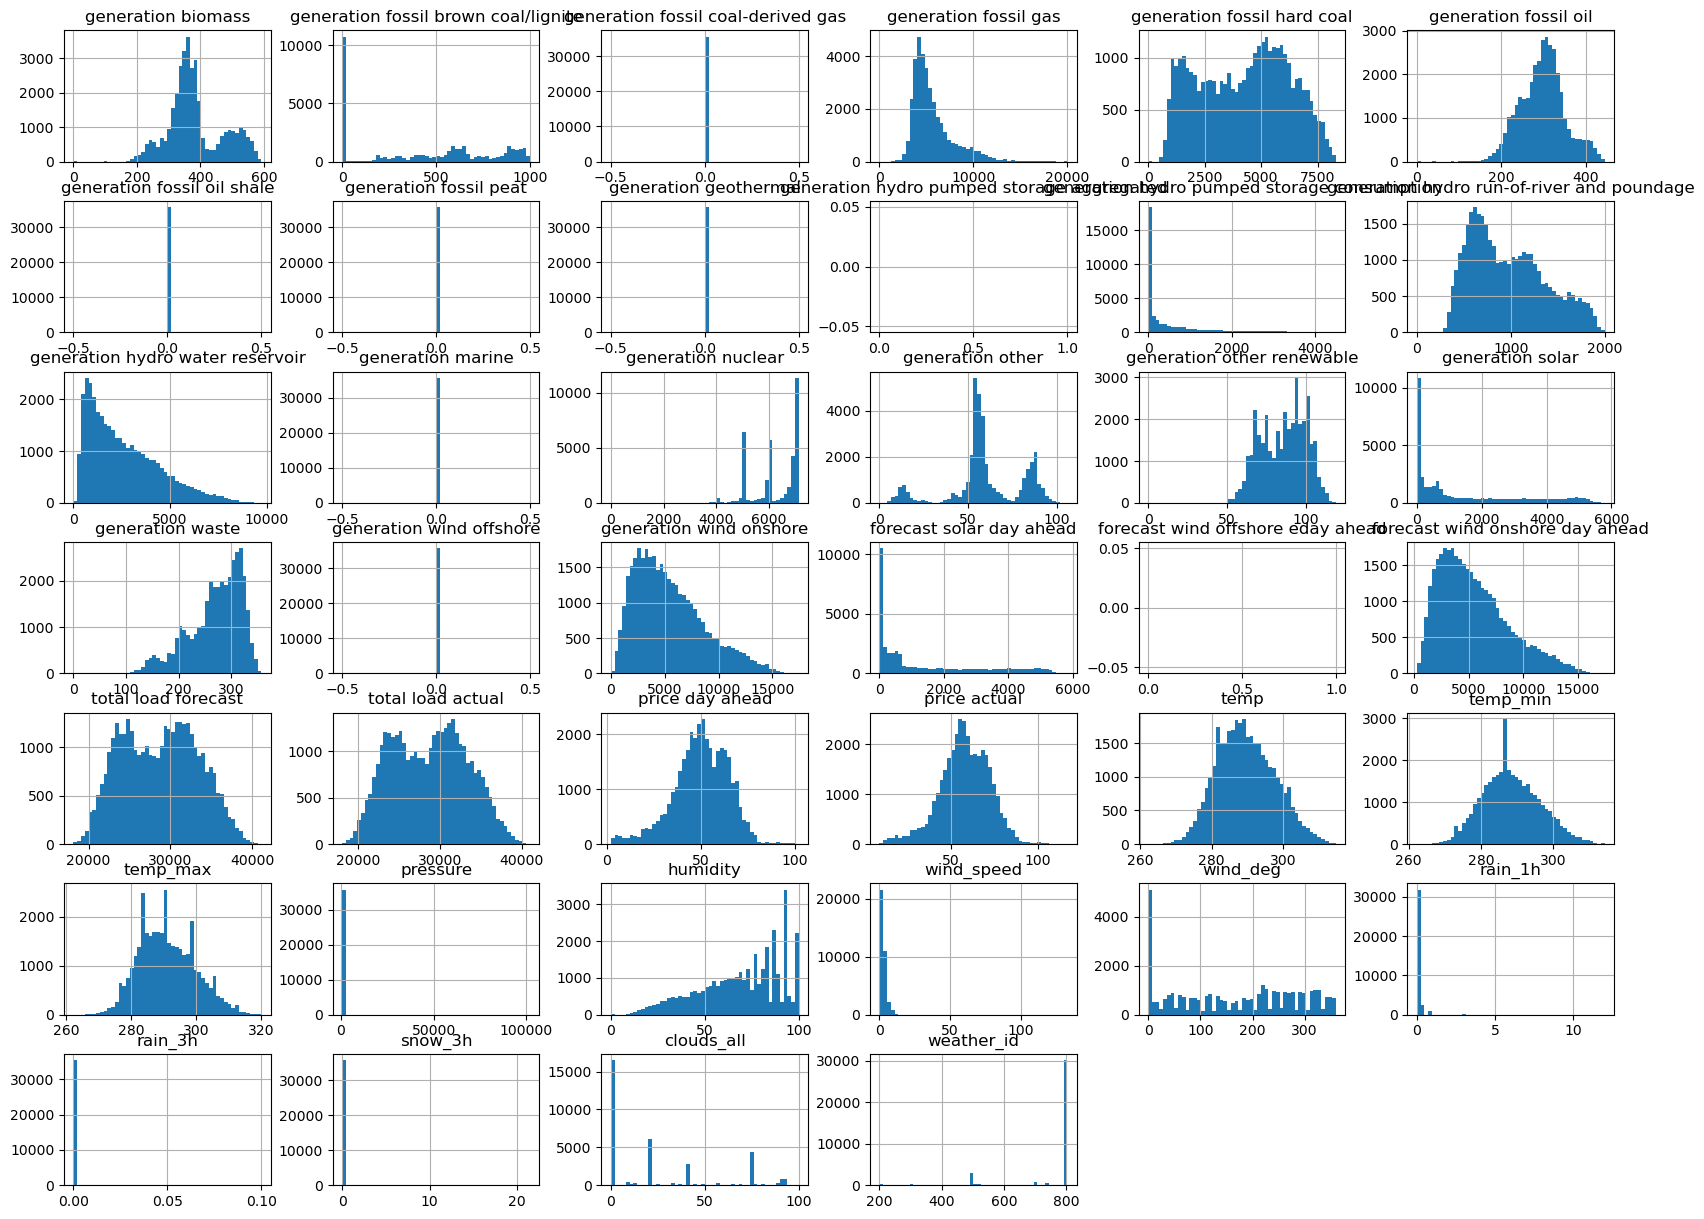

In [20]:
import matplotlib.pyplot as plt
downsampled_merged_dataset.hist(bins=50, figsize=(20,15))
plt.show()